# Linear Elasticity in 2D for 3 Phases

## Introduction

This example provides a demonstration of using PyMKS to compute the linear strain field for a three-phase composite material. It demonstrates how to generate data for delta microstructures and then use this data to calibrate the first order MKS influence coefficients. The calibrated influence coefficients are used to predict the strain response for a random microstructure and the results are compared with those from finite element. Finally, the influence coefficients are scaled up and the MKS results are again compared with the finite element data for a large problem.

PyMKS uses the finite element tool [SfePy](http://sfepy.org) to generate both the strain fields to fit the MKS model and the verification data to evaluate the MKS model's accuracy.

### Elastostatics Equations and Boundary Conditions

The governing equations for linear elasticity and the boundary conditions used in this example are the same as those provided in the [Linear Elastic in 2D example](./elasticity.ipynb). 

## Modeling with MKS

### Calibration Data and Delta Microstructures

The first order MKS influence coefficients are all that is needed to compute a strain field of a random microstructure as long as the ratio between the elastic moduli (also known as the contrast) is less than 1.5. If this condition is met we can expect a mean absolute error of 2%  or less when comparing the MKS results with those computed using finite element methods [[1]](#References). 

Because we are using distinct phases and the contrast is low enough to only need the first-order coefficients, delta microstructures and their strain fields are all that we need to calibrate the first-order influence coefficients [[2]](#References). 

The `generate_delta` function can be used to create the two delta microstructures needed to calibrate the first-order influence coefficients for a two phase microstructure. This function uses the Python module [SfePy](http://sfepy.org/doc-devel/index.html) to compute the strain fields using finite element methods.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import dask.array as da
import numpy as np
from sklearn.pipeline import Pipeline

from pymks import (
    generate_delta,
    plot_microstructures,
    solve_fe,
    PrimitiveTransformer,
    LocalizationRegressor,
    coeff_to_real,
    
)

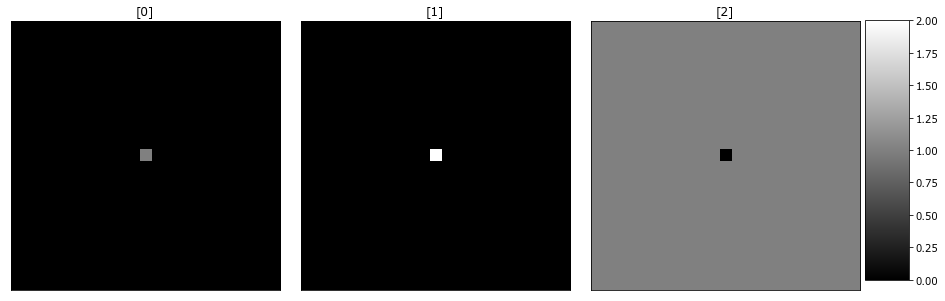

In [4]:
x_delta = generate_delta(n_phases=3, shape=(21, 21)).persist()

plot_microstructures(*x_delta[:3], titles=['[0]', '[1]', '[2]'], cmap='gray')

Using delta microstructures for the calibration of the first-order influence coefficients is essentially the same, as using a unit [impulse response](http://en.wikipedia.org/wiki/Impulse_response) to find the kernel of a system in signal processing. Any given delta microstructure is composed of only two phases with the center cell having an alternative phase from the remainder of the domain. The number of delta microstructures that are needed to calibrated the first-order coefficients is $N(N-1)$ where $N$ is the number of phases, therefore in this example 6 delta microstructures are required.

### Generating Calibration Data

In this example, the microstructures have three phases with elastic moduli values of 80, 100 and 120 and Poisson's ratio values all equal to 0.3. The macroscopic imposed strain is 0.02.

A helper function `strain_xx` is created to solve the finite element problem and return the $\varepsilon_{xx}$ component of the strain. The length of the values for the `elastic_modulus` and `poissons_ratio` parameteres indicate the number of phases.

In [10]:
strain_xx = lambda x: solve_fe(
        x,
        elastic_modulus=(80, 100, 120),
        poissons_ratio=(0.3, 0.3, 0.3),
        macro_strain=0.02
    )['strain'][...,0]

y_delta = strain_xx(x_delta).persist()

Observe strain field.

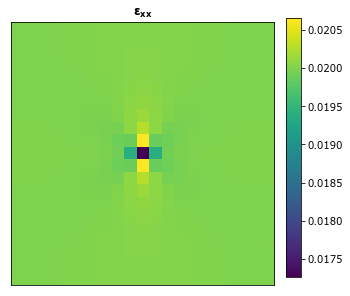

In [11]:
plot_microstructures(y_delta[0], titles=[r'$\mathbf{\varepsilon_{xx}}$'])

### Calibrating First-Order Influence Coefficients

Calibrate the influence coefficients by creating a model pipeline using the `PrimitiveTransformer` and the `LocalizationRegressor`.

In [7]:
model = Pipeline(steps=[
    ('discretize', PrimitiveTransformer(n_state=3, min_=0.0, max_=2.0)),
    ('regressor', LocalizationRegressor())
])

Now, pass the delta microstructures and their strain fields into the `fit` method to calibrate the first-order influence coefficients.

In [12]:
model.fit(x_delta, y_delta);

Observe the influence coefficients.

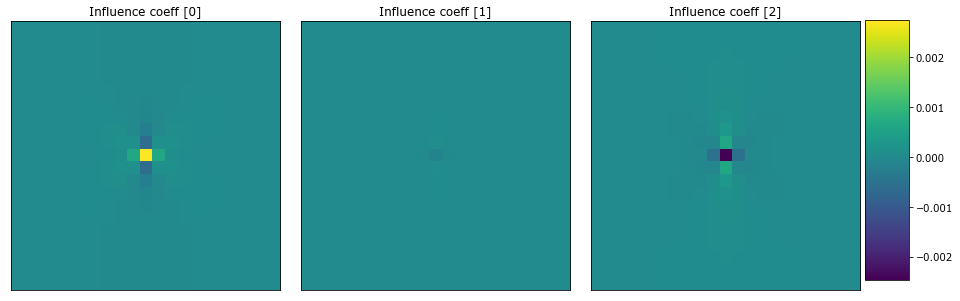

In [13]:
to_real = lambda x: coeff_to_real(x.steps[1][1].coeff).real

coeff = to_real(model)
plot_microstructures(
    coeff[..., 0],
    coeff[..., 1],
    coeff[..., 2],
    titles=['Influence coeff [0]', 'Influence coeff [1]', 'Influence coeff [2]']
)

### Predict of the Strain Field for a Random Microstructure

Use the calibrated `model` to compute the strain field for a random two phase microstructure and compare it with the results from a finite element simulation. The `strain_xx` helper function is used to generate the strain field.

In [14]:
da.random.seed(99)

x_data = da.random.randint(2, size=(1,) + x_delta.shape[1:]).persist()
y_data = strain_xx(x_data).persist()

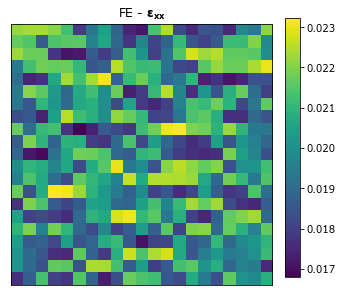

In [15]:
plot_microstructures(
    y_data[0],
    titles=[r'FE - $\mathbf{\varepsilon_{xx}}$']
)

**Note that the calibrated influence coefficients can only be used to reproduce the simulation with the same boundary conditions that they were calibrated with.**

Now to get the strain field from the model, pass the same microstructure to the `predict` method.

In [16]:
y_predict = model.predict(x_data)

Finall, compare the results from finite element simulation and the MKS model.

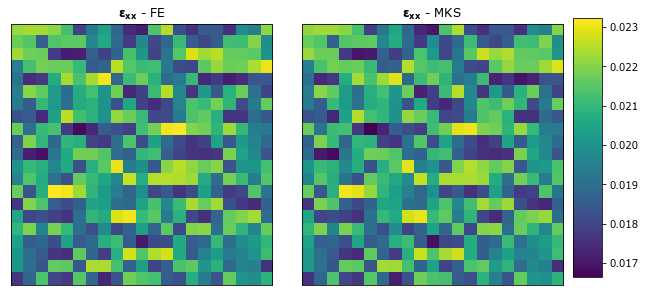

In [17]:
plot_microstructures(
    y_data[0],
    y_predict[0],
    titles=[
        r'$\mathbf{\varepsilon_{xx}}$ - FE',
        r'$\mathbf{\varepsilon_{xx}}$ - MKS'
    ]
)

Plot the difference between the two strain fields.

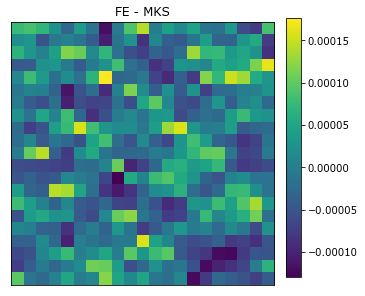

In [18]:
plot_microstructures(
    (y_data - y_predict)[0],
    titles=['FE - MKS']
)

The MKS model is able to capture the strain field for the random microstructure after being calibrated with delta microstructures.

## Resizing the Coefficeints to use on Larger Microstructures 

The influence coefficients that were calibrated on a smaller microstructure can be used to predict the strain field on a larger microstructure though spectral interpolation [[3]](#ref3), but accuracy of the MKS model drops slightly. To demonstrate how this is done, generate a new larger random microstructure and its strain field.

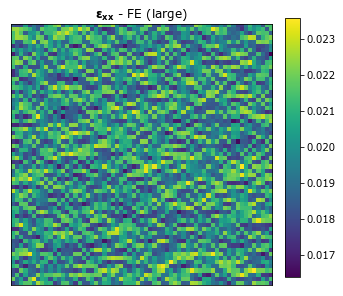

In [20]:
new_shape = tuple(np.array(x_delta.shape[1:]) * 3)
x_large = da.random.randint(2, size=(1,) + new_shape).persist()
y_large = strain_xx(x_large).persist()

plot_microstructures(y_large[0], titles=[r'$\mathbf{\varepsilon_{xx}}$ - FE (large)'])

The influence coefficients that have already been calibrated need to be resized to match the shape of the new larger microstructure that we want to compute the strain field for. This can be done by passing the shape of the new larger microstructure into the `coeff_resize` method.

In [21]:
model.steps[1][1].coeff_resize(x_large[0].shape);

Observe the resized influence coefficients.

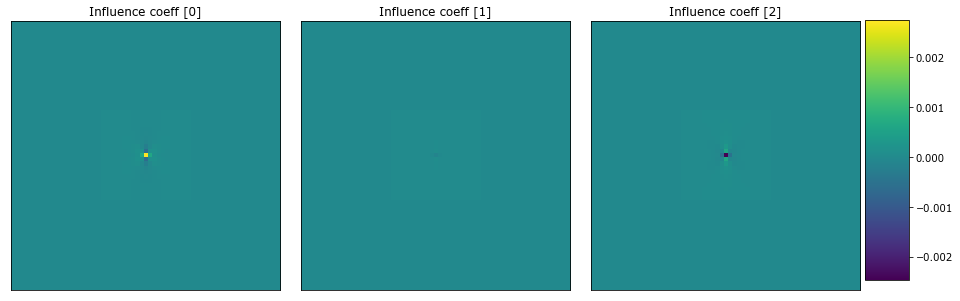

In [22]:
coeff_large = to_real(model)
plot_microstructures(
    coeff_large[..., 0],
    coeff_large[..., 1],
    coeff_large[..., 2],
    titles=['Influence coeff [0]', 'Influence coeff [1]', 'Influence coeff [2]']
)

The resized coefficients will only work with the large microstructure now.

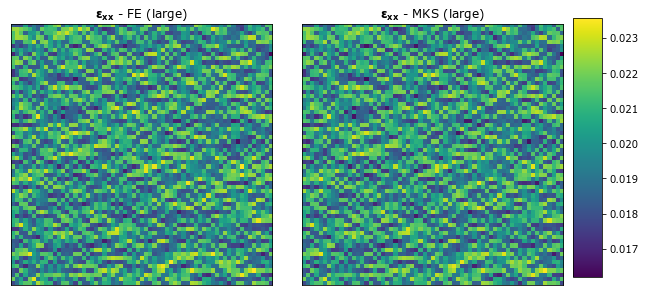

In [24]:
y_large_predict = model.predict(x_large).persist()

plot_microstructures(
    y_large[0],
    y_large_predict[0],
    titles=[
        r'$\mathbf{\varepsilon_{xx}}$ - FE (large)',
        r'$\mathbf{\varepsilon_{xx}}$ - MKS (large)'
    ]
)

Plot the difference between the two strain fields.

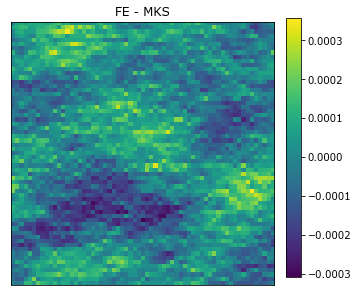

In [25]:
plot_microstructures(
    (y_large - y_large_predict)[0],
    titles=['FE - MKS']
)

The results from the strain field computed with the resized influence coefficients are not as accurate as they were before they were resized. This decrease in accuracy is expected when using spectral interpolation [[4]](#References).


## References

<a id="ref1"></a>
[1] Binci M., Fullwood D., Kalidindi S.R., A new spectral framework for establishing localization relationships for elastic behavior of composites and their calibration to finite-element models. Acta Materialia, 2008. 56 (10) p. 2272-2282 [doi:10.1016/j.actamat.2008.01.017](http://dx.doi.org/10.1016/j.actamat.2008.01.017).

<a id="ref2"></a>
[2] Landi, G., S.R. Niezgoda, S.R. Kalidindi, Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).

<a id="ref3"></a>
[3] Marko, K., Kalidindi S.R., Fullwood D., Computationally efficient database and spectral interpolation for fully plastic Taylor-type crystal plasticity calculations of face-centered cubic polycrystals. International Journal of Plasticity 24 (2008) 1264–1276 [doi:10.1016/j.ijplas.2007.12.002](http://dx.doi.org/10.1016/j.ijplas.2007.12.002).

<a id="ref4"></a>
[4] Marko, K. Al-Harbi H. F. , Kalidindi S.R., Crystal plasticity simulations using discrete Fourier transforms. Acta Materialia 57 (2009) 1777–1784 [doi:10.1016/j.actamat.2008.12.017](http://dx.doi.org/10.1016/j.actamat.2008.12.017).